In [10]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/Shared drives/476 final'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shared drives/476 final


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import pandas as pd
import re
import numpy as np
import scipy
import itertools
import matplotlib
import matplotlib.pyplot as plt
import gensim
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from gensim.models import KeyedVectors
from smart_open import open
from scipy.spatial.distance import cdist
from collections import Counter
from random import choice
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
#Storing the training and test datasets into their respective dataframes
trained = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#Creating a function that takes care of all the preprocessing stuff.
def preprocess():

  trained['Tweet'] = trained['Tweet'].str.lower() # Ensuring all words in the Tweet column of training data are lowercased
  test['Tweet'] = test['Tweet'].str.lower() # Ensuring all words in the Tweet column of test data are lowercased

  # Parsing the stop_words.txt file and storing all the words in a list.
  stopwords = []
  with open('stop_words.txt','r') as file:    
      for line in file:         
          for word in line.split():            
              stopwords.append(word)

  # Removing all stopwords from all the tweets in training data.
  trained["Tweet"] = trained["Tweet"].apply(lambda func: ' '.join(sw 
                                            for sw in func.split() 
                                            if sw not in stopwords))

  # Removing all stopwords from all the tweets in test data.
  test["Tweet"] = test["Tweet"].apply(lambda func: ' '.join(sw 
                                            for sw in func.split() 
                                            if sw not in stopwords))

  special_chars = ["!",'"',"%","&","amp","'","(",")", "*","+",",","-",".",
                  "/",":",";","<","=",">","?","[","\\","]","^","_",
                  "`","{","|","}","~","–","@","#","$"]

  #Training Data
  trained['Tweet'] = trained['Tweet'].str.replace(r'http?://[^\s<>"]+|www\.[^\s<>"]+', '') # Removing hyperlinks from all the tweets
  trained['Tweet'] = trained['Tweet'].str.replace('@[A-Za-z0-9]+', '') # Removing usernames from all the tweets.
  trained['Tweet'] = trained['Tweet'].str.replace(r'\B#\w*[a-zA-Z]+\w*', '') # Removing hashtags, including the text, from all the tweets
  trained['Tweet'] = trained['Tweet'].str.replace('\d+', '') # Removing numbers from all the tweets

  for c in special_chars:
      trained['Tweet'] = trained['Tweet'].str.replace(c,'') # Removing all special characters from all the tweets


#Test Data
  test['Tweet'] = test['Tweet'].str.replace(r'http?://[^\s<>"]+|www\.[^\s<>"]+', '') # Removing hyperlinks from all the tweets
  test['Tweet'] = test['Tweet'].str.replace('@[A-Za-z0-9]+', '') # Removing usernames from all the tweets.
  test['Tweet'] = test['Tweet'].str.replace(r'\B#\w*[a-zA-Z]+\w*', '') # Removing hashtags, including the text, from all the tweets
  test['Tweet'] = test['Tweet'].str.replace('\d+', '') # Removing numbers from all the tweets

  for c in special_chars:
      test['Tweet'] = test['Tweet'].str.replace(c,'') # Removing all special characters from all the tweets

  #Training Data
  train_unique = (list(set(trained['Tweet'].str.findall("\w+").sum()))) # Finding all the unique words in training data's Tweet column
  train_unique_words = len(train_unique)

  #Test Data
  test_unique = (list(set(test['Tweet'].str.findall("\w+").sum()))) # Finding all the unique words in test data's Tweet column
  test_unique_words = len(test_unique)

  # Making an empty column in our test data for predicted labels.
  test['Predicted Label'] = ''

  print("Unique words in Training Data: {}".format(train_unique_words))
  print("Unique words in Test Data: {}".format(test_unique_words))

In [14]:
preprocess()
trained.head()
test.head()

Unique words in Training Data: 10033
Unique words in Test Data: 4839


,Sentiment,Tweet,Predicted Label
0,neutral,jump dallasaustin market news,
1,positive,chicago seen seat a aa far great ride pdx,
2,negative,need bag bouncer get together,
3,negative,hey jetblue stranded entire plane supposed go...,
4,negative,big fail curbside baggage pittsburgh charge ...,


In [15]:
word2vec = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)

In [16]:
# Storing the training and test datasets into their respective dataframes

trained = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

"""# **Preprocessing**"""

#Storing the training and test datasets into their respective dataframes
trained = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
preprocess()

def extract_features(sentence):
  words = [word for word in sentence.split() if word in word2vec.vocab]
  if words == []:
    return []
  else:
    return np.mean(word2vec[words],axis=0)

train_embeddings = []

for sentence in trained['Tweet']:
  words = extract_features(sentence)
  if words == []:
    trained = trained.drop(trained[trained.Tweet == sentence].index)
  else:  
    train_embeddings.append(words)

test_embeddings = []

for sentence in test['Tweet']:
  words = extract_features(sentence)
  if words == []:
    test = test.drop(test[test.Tweet == sentence].index)
  else:  
    test_embeddings.append(words)

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

acc_list = []
rec_list = []
prec_list = []
f1_list = []

def classifying(trainfeatures,testfeatures,trained,test):

  X_train = trainfeatures 
  X_test = testfeatures
  y_train = trained.iloc[:,0].values
  y_test = test.iloc[:,0].values

  for k in [1,3,5,7,10]:

    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train, y_train)
    predicted_label = classifier.predict(X_test)

    accuracy_score = (metrics.accuracy_score(y_test,predicted_label))
    accuracy_score = (round(accuracy_score,2))*100
    acc_list.append(accuracy_score)

    cmatrix = confusion_matrix(y_test, predicted_label)
    creport = classification_report(y_test, predicted_label)

    macro_precision = (metrics.precision_score(y_test, predicted_label, average='macro'))
    macro_precision = (round(macro_precision,2))*100
    prec_list.append(macro_precision)

    macro_recall = (metrics.recall_score(y_test, predicted_label, average='macro'))
    macro_recall = (round(macro_recall,2))*100
    rec_list.append(macro_recall)
    
    macro_f1 = (metrics.f1_score(y_test, predicted_label, average='macro'))
    macro_f1 = (round(macro_f1,2))*100
    f1_list.append(macro_f1)

    print("\n\nConfusion Matrix for k = {} is:\n".format(k))
    print(cmatrix)
    print("\nClassification Report for k = {} is:\n".format(k))
    print(creport)
    print("Accuracy Score for k = {0} is: {1}%".format(k,accuracy_score))
    print("Macroaveraged Recall for k = {0} is: {1}%".format(k,macro_recall))
    print("Macroaveraged Precision for k = {0} is: {1}%".format(k,macro_precision))
    print("Macroaveraged F1-score for k = {0} is: {1}%".format(k,macro_f1))



Unique words in Training Data: 10033
Unique words in Test Data: 4839


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [17]:
# To run without outlier detection comment this out

clf = IsolationForest(max_samples=100, random_state=1)
clf.fit(train_embeddings)
y_pred_outliers = clf.predict(train_embeddings)
x = np.where(y_pred_outliers == -1)[0]
train_embeddings = np.delete(train_embeddings, x, axis=0)
trained = trained.drop(trained.index[x])





Confusion Matrix for k = 1 is:

[[1542  176  115]
 [ 305  222   84]
 [ 164   79  229]]

Classification Report for k = 1 is:

              precision    recall  f1-score   support

    negative       0.77      0.84      0.80      1833
     neutral       0.47      0.36      0.41       611
    positive       0.54      0.49      0.51       472

    accuracy                           0.68      2916
   macro avg       0.59      0.56      0.57      2916
weighted avg       0.67      0.68      0.67      2916

Accuracy Score for k = 1 is: 68.0%
Macroaveraged Recall for k = 1 is: 56.00000000000001%
Macroaveraged Precision for k = 1 is: 59.0%
Macroaveraged F1-score for k = 1 is: 56.99999999999999%


Confusion Matrix for k = 3 is:

[[1720   71   42]
 [ 404  151   56]
 [ 205   29  238]]

Classification Report for k = 3 is:

              precision    recall  f1-score   support

    negative       0.74      0.94      0.83      1833
     neutral       0.60      0.25      0.35       611
    positive 

<function matplotlib.pyplot.show>

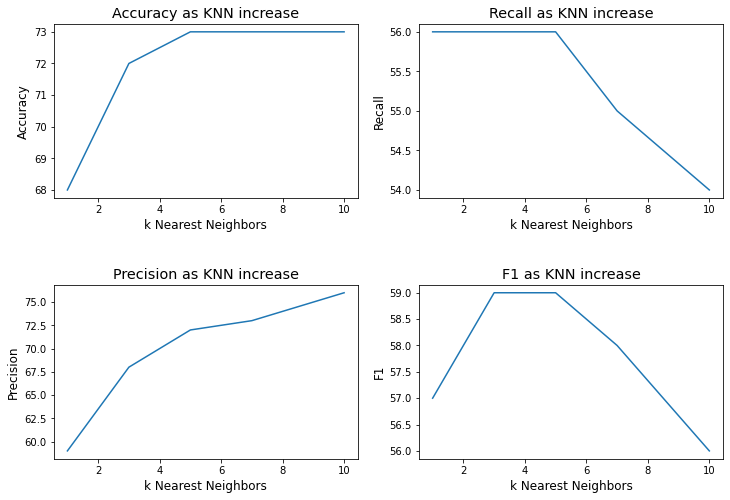

In [18]:
classifying(train_embeddings,test_embeddings,trained,test)

k_ls = [1,3,5,7,10] 

fig = plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(k_ls,acc_list)
plt.title("Accuracy as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("Accuracy",fontsize='large')

plt.subplot(2,2,2)
plt.plot(k_ls,rec_list)
plt.title("Recall as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("Recall",fontsize='large')

plt.subplot(2,2,3)
plt.plot(k_ls,prec_list)
plt.title("Precision as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("Precision",fontsize='large')

plt.subplot(2,2,4)
plt.plot(k_ls,f1_list)
plt.title("F1 as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("F1",fontsize='large')

fig.subplots_adjust(hspace=.5)

plt.show